In [502]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

In [503]:
from gensim import models

In [504]:
# Plotting tools
import pyLDAvis

In [505]:
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [506]:
#cleaning and filter the words
import datetime
import sys
import codecs
import re
import urllib, urllib2
import itertools, collections

import nltk  # Natural Language Processing
#nltk.download('punkt')
#nltk.download('all')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords # list of words
from collections import Counter  # optimized way to do this
import string  # list(string.punctuation) - produces a list of punctuations
import copy
from itertools import product, tee, combinations, chain
from nltk.stem import PorterStemmer
from operator import itemgetter # help with dataframes

from scipy.spatial.distance import cosine

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

#from tweepy import Stream

encodingTot = sys.stdout.encoding or 'utf-8'

In [507]:
SOME_FIXED_SEED = 42
# before training/inference: 
np.random.seed(SOME_FIXED_SEED)

## 0. Pre-define functions

let predefine some functions and constant to get ready for later processing

In [508]:
# Regex from Gagan ************************************************************

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

# Regex_str is used to GET text from CSV file

regex_str = [
    
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-signs
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)' # other words
]

# These Regex are used to EXCLUDE items from the text AFTER IMPORTING from csv with regex_str

numbers = r'(?:(?:\d+,?)+(?:\.?\d+)?)'
URL = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
html_tag = r'<[^>]+>'
hash_tag = r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"
at_sign = r'(?:@[\w_]+)'
dash_quote = r"(?:[a-z][a-z'\-_]+[a-z])"
other_word = r'(?:[\w_]+)'
other_stuff = r'(?:\S)' # anything else - NOT USED
start_pound = r"([#?])(\w+)" # Start with #
start_quest_pound = r"(?:^|\s)([#?])(\w+)" # Start with ? or with #
cont_number = r'(\w*\d\w*)' # Words containing numbers

# My REGEX **************************************************************************

#      Remove '[' and ']' brackets

sq_br_f = r'(?:[[\w_]+)' # removes '['
sq_br_b = r'(?:][\w_]+)' # removes ']'

rem_bracket = r'(' + '|'.join([sq_br_f, sq_br_b]) +')'
rem_bracketC = re.compile(rem_bracket, re.VERBOSE)

# Removes all words of 2 characters or less *****************************************************

short_words = r'\W*\b\w{1,2}\b' # Short words of 3 character or less
short_wordsC = re.compile(short_words, re.VERBOSE | re.IGNORECASE)

# REGEX remove all words with \ and / combinations

slash_back =  r'\s*(?:[\w_]*\\(?:[\w_]*\\)*[\w_]*)'
slash_fwd = r'\s*(?:[\w_]*/(?:[\w_]*/)*[\w_]*)'
slash_all = r'\s*(?:[\w_]*[/\\](?:[\w_]*[/\\])*[\w_]*)'

# REGEX numbers, short words and URL only to EXCLUDE +++++++++++++++++++++++++++++++++++++++++++++++++++

num_url_short = r'(' + '|'.join([numbers, URL, short_words + sq_br_f + sq_br_b]) +')'  # Exclude from tweets
comp_num_url_short = re.compile(num_url_short, re.VERBOSE | re.IGNORECASE)

# Master REGEX to INCLUDE from the original tweets ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

list_regex = r'(' + '|'.join(regex_str) + ')'

master_regex = re.compile(list_regex, re.VERBOSE | re.IGNORECASE) # TAKE from tweets INITIALLY

In [509]:
char_remove = [']', '[', '(', ')', '{', '}'] # characters to be removed

#the other 3character length words will be removed
words_keep = ['old', 'new', 'age', 'lot', 'bag', 'top', 'cat', 'bat', 'sap', 'jda', 'tea', 'dog', 'lie', 'law', 'lab',\
             'mob', 'map', 'car', 'fat', 'sea', 'saw', 'raw', 'rob', 'win', 'can', 'get', 'fan', 'fun', 'big',\
             'use', 'pea', 'pit','pot', 'pat', 'ear', 'eye', 'kit', 'pot', 'pen', 'bud', 'bet', 'god', 'tax', 'won', 'run',\
              'lid', 'log', 'pr', 'pd', 'cop', 'nyc', 'ny', 'la', 'toy', 'war', 'law', 'lax', 'jfk', 'fed', 'cry', 'ceo',\
              'pay', 'pet', 'fan', 'fun', 'usd', 'rio']

emotion_list = [':)', ';)', '(:', '(;', '}', '{','}']


word_garb = ['here', 'there', 'where', 'when', 'would', 'should', 'could','thats', 'youre', 'thanks', 'hasn',\
             'thank', 'https', 'since', 'wanna', 'gonna', 'aint', 'http', 'unto', 'onto', 'into', 'havent',\
             'dont', 'done', 'cant', 'werent', 'https', 'u', 'isnt', 'go', 'theyre', 'each', 'every', 'shes', 'youve', 'youll',\
            'weve', 'theyve']

extra_word_garb = []

#extra_word_garb = ['today','london','greater']

# Dictionary with Replacement Pairs ******************************************************************************
#repl_dict = {'googleele': 'goog', 'lyin': 'lie', 'googles': 'goog', 'aapl':'apple',\
#             'msft':'microsoft', 'google': 'goog', 'googl':'goog'}

repl_dict = {}

exclude = list(string.punctuation) + emotion_list + word_garb + extra_word_garb

# Convert tuple to a list, then to a string; Remove the characters; Stays as a STRING. Porter Stemmer

stemmer=PorterStemmer()
lmtzr = WordNetLemmatizer()

Prerequisites – Download nltk stopwords and spacy model

We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

Lemmatization is nothing but converting a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.

##### Run in python console
import nltk; nltk.download('stopwords')

##### Run in terminal or command prompt
python3 -m spacy download en

## 1. Prepare Stopwords

We have already downloaded the stopwords. Let’s import them and make it available in stop_words.

In [510]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## 2. Load tweets data

first test the methods and then write a loop to auto process all data sets

In [511]:
filename = 'tw_london2017_q2'

In [512]:
directory = 'data/'+ filename + '.csv'
#open tweets 
tw_ori = pd.read_csv(open(directory,'rU'), encoding='utf-8', engine='c', header = 0, 
                     error_bad_lines=False,parse_dates=True)


In [513]:
tw_ori.columns

Index([ u'Unnamed: 0',          u'id',        u'text',      u'userid',
               u'lat',         u'lon',  u'created_at',    u'location',
          u'geometry',        u'time', u'index_right',    u'MSOA11CD',
          u'MSOA11NM',     u'LAD11CD',     u'LAD11NM',     u'RGN11CD',
           u'RGN11NM',    u'USUALRES',    u'HHOLDRES',   u'COMESTRES',
            u'POPDEN',      u'HHOLDS',   u'AVHHOLDSZ'],
      dtype='object')

In [514]:
df = tw_ori[['id','text','userid','lat','lon','created_at','location','geometry','time','MSOA11CD']]

In [515]:
print("number of records is.%s" % str(len(df)))

number of records is.234791


In [516]:
df = df.sample(int(len(df)*1))
print('remain sample size is %d' %len(df))
print(df.sample(3))

remain sample size is 234791
                        id                                               text  \
125996  875290329045454848  Good Morning London. #workperks @ Stanford Bri...   
44571   858080475331653633  No1 Neapolitan Organic Sourdough Pizza in Vict...   
64591   854721484371218432  HIPS LIKE CINDERELLA #SuferRosa #Pixies ochota...   

              userid        lat       lon           created_at     location  \
125996  8.038921e+07  51.481816 -0.190326  2017-06-15 09:54:11  Hammersmith   
44571   2.399939e+09  51.497741 -0.144007  2017-04-28 22:08:22       London   
64591   9.057225e+08  51.527105 -0.079495  2017-04-19 15:40:56      Hackney   

                                    geometry          time   MSOA11CD  
125996       POINT (-0.19032552 51.48181562)  1.497517e+09  E02000391  
44571        POINT (-0.14400678 51.49774137)  1.493414e+09  E02000979  
64591   POINT (-0.0794946 51.52710510000001)  1.492613e+09  E02000371  


## 3. Preliminary data processing

In [517]:
def filterPick(list, filter):
    return [ ( l, m.group(1) ) for l in list for m in (filter(l),) if m]

search_regex = re.compile(list_regex, re.VERBOSE | re.IGNORECASE).search

import sys
stdi,stdo,stde=sys.stdin,sys.stdout,sys.stderr
reload(sys)
sys.setdefaultencoding('utf8')
sys.stdin,sys.stdout,sys.stderr=stdi,stdo,stde
print (sys.stdout)

# Convert to list
#tweet_list_org = df.text.values.tolist()

tweet_list_org = [str(l).encode('ascii','ignore') for l in df.text]
len(tweet_list_org)

234791


### Remove hashtag, URL, and at_sign characters
As you can see there are many emails, newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions.

In [518]:
from time import time

#outlist_init = filterPick(tweet_list_org, search_regex) # It is a tuple: initial list from all tweets in area
outlist_init = tweet_list_org

t0 = time()
outlist_init = [re.sub(URL, "", str(tw_clean)) for tw_clean in outlist_init]
print("URL done in %0.3fs." % (time() - t0))
print("number of records after URL is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(html_tag, "",str(tw_clean)) for tw_clean in outlist_init]
print("HTML_TAG done in %0.3fs." % (time() - t0))
print("number of records after HTML_TAG is %0.fs." % len(outlist_init))

t0 = time()
outlist_init = [re.sub(hash_tag, "",str(tw_clean)) for tw_clean in outlist_init]
print("hash_tag done in %0.3fs." % (time() - t0))
print("number of records after hash_tag is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(slash_all,"", str(tw_clean)) for tw_clean in outlist_init]
print("slash_all done in %0.3fs." % (time() - t0))
print("number of records after slash_all is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(cont_number, "",str(tw_clean)) for tw_clean in outlist_init]
print("cont_number done in %0.3fs." % (time() - t0))
print("number of records after cont_number is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(numbers, "",str(tw_clean)) for tw_clean in outlist_init]
print("numbers done in %0.3fs." % (time() - t0))
print("number of records after outlist_init is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(start_pound, "",str(tw_clean)) for tw_clean in outlist_init]
print("pound done in %0.3fs." % (time() - t0))
print("number of records after pound is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(start_quest_pound, "",str(tw_clean)) for tw_clean in outlist_init]
print("marks done in %0.3fs." % (time() - t0))
print("number of records after marks is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub(at_sign, "",str(tw_clean)) for tw_clean in outlist_init]
print("at_sign done in %0.3fs." % (time() - t0))
print("number of records after at_sign is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub("'", "",str(tw_clean)) for tw_clean in outlist_init]
print("quotation done in %0.3fs." % (time() - t0))
print("number of records after quotation is %0.fs." % len(outlist_init))


t0 = time()
outlist_init = [re.sub('"', "",str(tw_clean)) for tw_clean in outlist_init]
print("double quotation done in %0.3fs." % (time() - t0))
print("number of records after double is %0.fs." % len(outlist_init))


t0 = time()
# Removes # and @ in words (lookahead)
outlist_init = [re.sub(r'(?:^|\s)[@#].*?(?=[,;:.!?]|\s|$)', r'', tw_clean) for tw_clean in outlist_init] 
print("symbols done in %0.3fs." % (time() - t0))
print("number of records after symbols is %0.fs." % len(outlist_init))

#data = [" ".join(i) for i in outlist_init]
# Removes shortwords
t0 = time()
outlist_init = [re.sub(short_words, "",str(tw_clean)) for tw_clean in outlist_init]
print("remove shortwords done in %0.3fs." % (time() - t0))
print("number of records after shortwords is %0.fs." % len(outlist_init))

pprint(outlist_init[0])
data = outlist_init

URL done in 1.068s.
number of records after URL is 234791s.
HTML_TAG done in 0.496s.
number of records after HTML_TAG is 234791s.
hash_tag done in 1.189s.
number of records after hash_tag is 234791s.
slash_all done in 2.910s.
number of records after slash_all is 234791s.
cont_number done in 2.203s.
number of records after cont_number is 234791s.
numbers done in 1.101s.
number of records after outlist_init is 234791s.
pound done in 0.668s.
number of records after pound is 234791s.
marks done in 0.977s.
number of records after marks is 234791s.
at_sign done in 0.612s.
number of records after at_sign is 234791s.
quotation done in 0.567s.
number of records after quotation is 234791s.
double quotation done in 0.366s.
number of records after double is 234791s.
symbols done in 1.174s.
number of records after symbols is 234791s.
remove shortwords done in 2.024s.
number of records after shortwords is 234791s.
u'Getting ready for   Thank you japfashion for lippy jacket  '


In [519]:
len(data)

234791

After removing the emails and extra spaces, the text still looks messy. It is not ready for the LDA to consume. You need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.

Gensim’s simple_preprocess is great for this.

## 3. Tokenize words and Clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [520]:
import sys
stdi,stdo,stde=sys.stdin,sys.stdout,sys.stderr
reload(sys)
sys.setdefaultencoding('utf8')
sys.stdin,sys.stdout,sys.stderr=stdi,stdo,stde
print (sys.stdout)

In [521]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[0])

[u'getting', u'ready', u'for', u'thank', u'you', u'japfashion', u'for', u'lippy', u'jacket']


## 4. Creating Bigram and Trigram Models (this is very important)
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘london_bridge’, ‘regent_park’, etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [522]:
#Build the bigram and trigram models

t0 = time()
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count=5, threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print("building phrases done in %0.3fs." % (time() - t0))

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

building phrases done in 27.532s.
[u'getting', u'ready', u'for', u'thank', u'you', u'japfashion', u'for', u'lippy', u'jacket']


## 5. Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [523]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]



In [524]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_trigrams(data_words_nostops)

In [525]:
from __future__ import unicode_literals
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

#nlp = spacy.load('en', disable=['parser', 'ner'])

In [526]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [527]:
# Do lemmatization keeping only noun, adj, vb, adv

t0 = time()
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print("lemmatization done in %0.3fs." % (time() - t0))

print(data_lemmatized[0])

lemmatization done in 567.151s.
[u'get', u'ready', u'thank', u'japfashion', u'lippy', u'jacket']


In [528]:
data_lemmatized_out = [" ".join(i) for i in data_lemmatized]
data_lemmatized_out = pd.DataFrame(data_lemmatized_out)
to_filename = 'output/cleaned_tw_'+ filename
to_filename
#data_lemmatized_out.to_csv(to_filename, encoding='utf-8' )

u'output/cleaned_tw_tw_london2017_q2'

In [529]:
data_lemmatized[6]

[u'go', u'thank', u'dark', u'slice', u'break']

## 6. Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [530]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [531]:
id2word[0]

u'lippy'

In [532]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(u'lippy', 1),
  (u'thank', 1),
  (u'get', 1),
  (u'jacket', 1),
  (u'ready', 1),
  (u'japfashion', 1)]]

## 7. Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [534]:
# Build LDA model
t0 = time()

lda_model_10_10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=50,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
print("Topic model building done in %0.3fs." % (time() - t0))

Topic model building done in 2120.718s.


## 8. View the topics in LDA model

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [535]:
# Print the Keyword in the 10 topics
pprint(lda_model_10_10.print_topics())
doc_lda = lda_model_10_10[corpus]

[(0,
  u'0.043*"night" + 0.036*"last" + 0.025*"look" + 0.019*"posted_photo" + 0.019*"morning" + 0.014*"house" + 0.014*"little" + 0.014*"year" + 0.012*"saturday" + 0.011*"tomorrow"'),
 (1,
  u'0.047*"make" + 0.027*"weekend" + 0.023*"s" + 0.020*"friday" + 0.020*"yesterday" + 0.019*"feel" + 0.019*"be" + 0.017*"place" + 0.016*"still" + 0.014*"session"'),
 (2,
  u'0.084*"amp" + 0.050*"time" + 0.029*"lovely" + 0.028*"drink" + 0.018*"home" + 0.017*"bar" + 0.017*"food" + 0.015*"life" + 0.015*"know" + 0.011*"man"'),
 (3,
  u'0.027*"have" + 0.021*"next" + 0.019*"much" + 0.018*"well" + 0.017*"find" + 0.016*"need" + 0.014*"ever" + 0.014*"favourite" + 0.014*"soho" + 0.012*"shoot"'),
 (4,
  u'0.093*"day" + 0.036*"week" + 0.026*"back" + 0.024*"first" + 0.021*"start" + 0.016*"view" + 0.014*"meet" + 0.013*"play" + 0.013*"want" + 0.012*"full"'),
 (5,
  u'0.041*"tonight" + 0.033*"beautiful" + 0.022*"fun" + 0.021*"sunday" + 0.020*"people" + 0.020*"always" + 0.017*"party" + 0.016*"sun" + 0.016*"think" + 0.

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

## 9. Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [536]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_10_10.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_10_10, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(u'\nPerplexity: ', -9.4777320729713921)
(u'\nCoherence Score: ', 0.38168599678220461)


## 10. Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [537]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_10_10, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      13.669491        1       1  0.056724 -0.389113
9      12.879781        1       2 -0.399746 -0.012179
6      11.294244        1       3  0.048698  0.048599
2      10.069889        1       4  0.043307  0.048038
4       9.478996        1       5  0.044175  0.053195
7       9.100214        1       6  0.042212  0.052991
3       8.751888        1       7  0.041694  0.050995
8       8.535793        1       8  0.040894  0.048511
1       8.332330        1       9  0.041081  0.050893
5       7.887374        1      10  0.040960  0.048069, topic_info=      Category          Freq        Term         Total  loglift  logprob
term                                                                    
50671  Default  48184.000000      london  48184.000000  30.0000  30.0000
58525  Default  21707.000000       great  21707.000000  29.0000  29.0000
67947  Default  10677.000000         day  10677.000000  28.0000  28.0000
6526   Default  10317.000000         amp  10317.000000  27.0000  27.0000
10767  Default   8061.000000         get   8061.000000  26.0000  26.0000
14928  Default   8119.000000       today   8119.000000  25.0000  25.0000
41538  Default   8514.000000        good   8514.000000  24.0000  24.0000
27463  Default   7544.000000         new   7544.000000  23.0000  23.0000
5422   Default   7189.000000       night   7189.000000  22.0000  22.0000
56123  Default   6088.000000        time   6088.000000  21.0000  21.0000
5990   Default   5475.000000         not   5475.000000  20.0000  20.0000
19456  Default   5816.000000        love   5816.000000  19.0000  19.0000
65568  Default   5645.000000       thank   5645.000000  18.0000  18.0000
2925   Default   6020.000000        last   6020.000000  17.0000  17.0000
46615  Default   4718.000000        make   4718.000000  16.0000  16.0000
59733  Default   4280.000000        work   4280.000000  15.0000  15.0000
70589  Default   4718.000000        come   4718.000000  14.0000  14.0000
3888   Default   3971.000000     tonight   3971.000000  13.0000  13.0000
23364  Default   4096.000000          do   4096.000000  12.0000  12.0000
20803  Default   4125.000000        week   4125.000000  11.0000  11.0000
21114  Default   4255.000000         see   4255.000000  10.0000  10.0000
44241  Default   4081.000000        look   4081.000000   9.0000   9.0000
9777   Default   3524.000000      lovely   3524.000000   8.0000   8.0000
20656  Default   3184.000000   beautiful   3184.000000   7.0000   7.0000
40824  Default   3480.000000       drink   3480.000000   6.0000   6.0000
48544  Default   3538.000000        park   3538.000000   5.0000   5.0000
19212  Default   3505.000000       happy   3505.000000   4.0000   4.0000
9242   Default   3055.000000     amazing   3055.000000   3.0000   3.0000
26240  Default   3078.000000          go   3078.000000   2.0000   2.0000
12938  Default   2905.000000        have   2905.000000   1.0000   1.0000
...        ...           ...         ...           ...      ...      ...
3888   Topic10   3970.180806     tonight   3971.022845   2.5397  -3.1837
20656  Topic10   3183.847226   beautiful   3184.689256   2.5396  -3.4044
30459  Topic10   2062.905382         fun   2063.747430   2.5395  -3.8384
28759  Topic10   2052.973481      sunday   2053.815492   2.5395  -3.8432
19100  Topic10   1938.679258      people   1939.521302   2.5395  -3.9005
20792  Topic10   1901.592825      always   1902.434867   2.5395  -3.9198
8674   Topic10   1626.327922       party   1627.169975   2.5394  -4.0762
15990  Topic10   1576.518125         sun   1577.360166   2.5394  -4.1073
47337  Topic10   1535.453292       think   1536.295337   2.5394  -4.1337
42223  Topic10   1451.934138         way   1452.776136   2.5393  -4.1896
21752  Topic10   1416.829229         let   1417.671278   2.5393  -4.2141
13733  Topic10   1085.485366       would   1086.327362   2.5391  -4.4805
73298  Topic10    937.84

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

## 11. Building LDA Mallet Model

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

https://anoopacademia.wordpress.com/2015/01/18/install-mallet-on-windows-operating-system/

In [538]:
#import tempfile
#tempfile.tempdir='F:/'

#import os 
#os.environ.update({'MALLET_HOME':r'F:/workspace/python/mallet-2.0.8/'})


In [539]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = 'F:/workspace/python/mallet-2.0.8/bin/mallet' # update this path

mallet_path = '/Users/chenzhong/mallet-2.0.7/bin/mallet' # update this path

In [540]:
# Build LDA model
t0 = time()
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, num_topics=10, 
                                             iterations = 50, id2word=id2word)
print("Topic model building using mallet done in %0.3fs." % (time() - t0))

Topic model building using mallet done in 47.154s.


In [541]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score

coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [(u'london', 0.035729289),
   (u'great', 0.020922221),
   (u'amp', 0.015077816),
   (u'night', 0.0073288456),
   (u'today', 0.005723035),
   (u'love', 0.0056016655),
   (u'tonight', 0.0049668103),
   (u'day', 0.0043132827),
   (u'good', 0.0040051909),
   (u'nice', 0.0037157715)]),
 (1,
  [(u'london', 0.029500701),
   (u'great', 0.013793747),
   (u'amp', 0.011824545),
   (u'good', 0.010247317),
   (u'time', 0.0096873539),
   (u'day', 0.0096126925),
   (u'today', 0.0092767151),
   (u'friday', 0.0060849278),
   (u'night', 0.0059542698),
   (u'people', 0.0050303312)]),
 (2,
  [(u'london', 0.074672535),
   (u'great', 0.036683209),
   (u'amp', 0.014731127),
   (u'day', 0.010663508),
   (u'today', 0.010029107),
   (u'good', 0.0088815913),
   (u'time', 0.0063346643),
   (u'love', 0.005961488),
   (u'city', 0.0052897711),
   (u'park', 0.0049539129)]),
 (3,
  [(u'london', 0.034240823),
   (u'great', 0.014368084),
   (u'amp', 0.013276483),
   (u'good', 0.0086395107),
   (u'day', 0.00842492

## 12. How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [542]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [543]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=6, step=1)

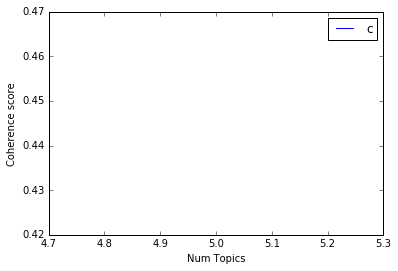

In [544]:
# Show graph
limit=6; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [545]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

(u'Num Topics =', 5, u' has Coherence Value of', 0.446)


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [546]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  u'0.052*"amp" + 0.032*"night" + 0.023*"time" + 0.018*"tonight" + 0.015*"back" + 0.014*"show" + 0.011*"bar" + 0.010*"evening" + 0.010*"fun" + 0.009*"home"'),
 (1,
  u'0.038*"today" + 0.018*"week" + 0.015*"make" + 0.010*"ready" + 0.009*"summer" + 0.007*"set" + 0.007*"session" + 0.007*"studio" + 0.007*"event" + 0.007*"check"'),
 (2,
  u'0.052*"day" + 0.039*"good" + 0.018*"happy" + 0.017*"morning" + 0.015*"lovely" + 0.015*"beautiful" + 0.014*"weekend" + 0.012*"birthday" + 0.012*"amazing" + 0.012*"sunday"'),
 (3,
  u'0.029*"love" + 0.018*"work" + 0.017*"drink" + 0.011*"year" + 0.009*"life" + 0.008*"people" + 0.008*"find" + 0.008*"nice" + 0.007*"coffee" + 0.006*"meet"'),
 (4,
  u'0.241*"london" + 0.109*"great" + 0.017*"posted_photo" + 0.016*"park" + 0.011*"house" + 0.009*"city" + 0.008*"garden" + 0.008*"street" + 0.008*"view" + 0.007*"hotel"')]


## 18. Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [547]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):  #=lda_model
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


t0 = time()
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)
print("Assigning the dominant topic used %0.3fs." % (time() - t0))

Assigning the dominant topic used 5509.289s.


In [548]:
len(data)

234791

(array([ 35093.,  39334.,  43501.,  47409.,  69454.]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <a list of 5 Patch objects>)

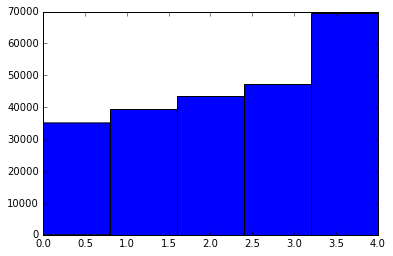

In [549]:
plt.hist(df_dominant_topic['Dominant_Topic'],5)

## Summarise the dominant topic for each zone

In [487]:
import pysal as ps
import random
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

from pysal.contrib.viz import mapping as maps


#wknn5 = ps.weights.KNN.from_shapefile('data/london_msoa.shp', k=10)

In [488]:
df['topic'] = np.array(df_dominant_topic['Dominant_Topic'])

In [489]:
df_count = df.groupby(['MSOA11CD'])['id'].count()
summary = pd.DataFrame(df.groupby(['MSOA11CD', 'topic'])['id'].count())
summary = pd.DataFrame(summary.unstack())
summary.head(3)

id                            
topic        0.0    1.0    2.0    3.0    4.0
MSOA11CD                                    
E02000001  125.0  187.0  139.0  186.0  252.0
E02000003    1.0    1.0    NaN    NaN    1.0
E02000004    NaN    NaN    NaN    7.0    2.0

In [490]:
a = range(5) 
a = map(str, a)
colsnames = a + ['MSOA11CD']

In [491]:
df_summary = pd.DataFrame(summary.iloc[:,:].values)
df_summary['MSOA11CD'] = summary.index.values
df_summary.columns = colsnames
df_summary = df_summary.fillna(0)
df_summary['count'] = df_count.values

In [492]:
df_summary.head(3)

,0,1,2,3,4,MSOA11CD,count
0,125.0,187.0,139.0,186.0,252.0,E02000001,889
1,1.0,1.0,0.0,0.0,1.0,E02000003,3
2,0.0,0.0,0.0,7.0,2.0,E02000004,9


In [493]:
def getMaxindex(c):
    return c.index(max(c))

In [494]:
df_summary_c = df_summary.iloc[:,0:5]
#rs = df_summary_c.apply(lambda x: getMaxindex(x.tolist()))
rs = [getMaxindex(row[0:5].tolist()) for index, row in df_summary_c.iterrows()]

In [495]:
df_summary['dom_topic'] = rs

In [496]:
shp_path = 'data/london_msoa.shp'
data_table = pd.DataFrame(ps.pdio.read_files(shp_path))

In [497]:
data_table.head(3)

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,<pysal.cg.shapes.Polygon object at 0x176163dd0>
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,<pysal.cg.shapes.Polygon object at 0x176163f90>
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,<pysal.cg.shapes.Polygon object at 0x176163650>


In [498]:
df_summary.dtypes

0            float64
1            float64
2            float64
3            float64
4            float64
MSOA11CD      object
count          int64
dom_topic      int64
dtype: object

In [499]:
test =  pd.concat([data_table, df_summary], axis=1, join='outer')
test.head(3)

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,...,AVHHOLDSZ,geometry,0,1,2,3,4,MSOA11CD,count,dom_topic
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,...,1.6,<pysal.cg.shapes.Polygon object at 0x176163dd0>,125.0,187.0,139.0,186.0,252.0,E02000001,889.0,4.0
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,...,2.5,<pysal.cg.shapes.Polygon object at 0x176163f90>,1.0,1.0,0.0,0.0,1.0,E02000003,3.0,0.0
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,...,2.6,<pysal.cg.shapes.Polygon object at 0x176163650>,0.0,0.0,0.0,7.0,2.0,E02000004,9.0,3.0


In [500]:
values = test['dom_topic'].fillna(-1)

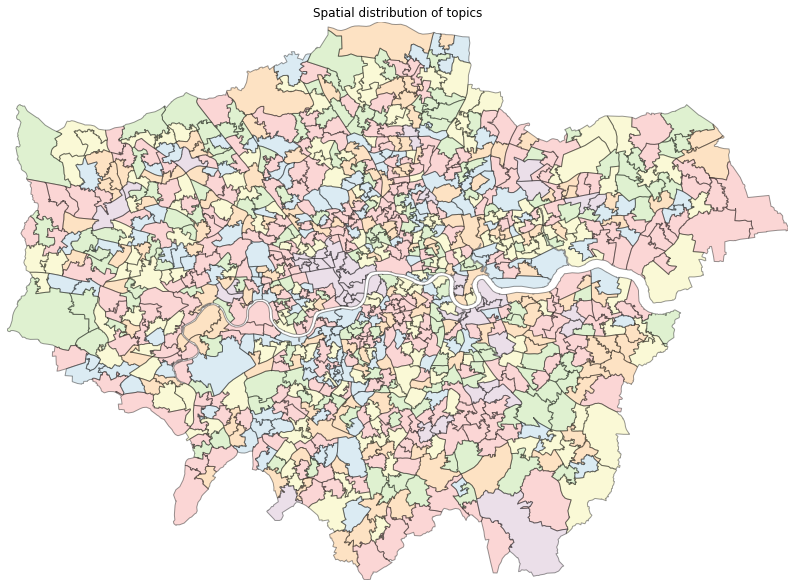

In [501]:
shp_link = 'data/london_msoa.shp'
shp = ps.open(shp_link)

#types = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']
types = 'unique_values'
maps.plot_choropleth(shp_link, values, types, title='Spatial distribution of topics', figsize=(14, 10))

## 19. Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [92]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7916,"park, today, amp, love, day, make, work, morni...",( Thats pretty awful. Such shame there are man...
1,1.0,0.6804,"day, greenwich, great, today, good, time, park...",(Active year These two terrors cleotyso...
2,2.0,0.7038,"london, great, amp, good, paddington, day, tim...",( Source: Tower Bridge twilight James. Petts ...
3,3.0,0.6564,"day, today, morning, amp, good, love, time, se...",(Another Year Another Opportunity Chec...
4,4.0,0.7265,"amp, day, night, good, today, drink, tonight, ...",(This awesome! Cheers Good weekend starts wi...


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.



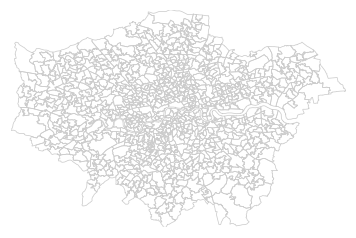

In [139]:
fig = plt.figure()

base = maps.map_poly_shp(shp)
base.set_facecolor('none')
base.set_linewidth(0.75)
base.set_edgecolor('0.8')

ax = maps.setup_ax([base], [shp.bbox, shp.bbox, shp.bbox])
fig.add_axes(ax)
plt.show()

## 20. Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [140]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

TypeError: cannot convert the series to <type 'float'>

## 21. Conclusion

We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.

Hope you enjoyed reading this. I would appreciate if you leave your thoughts in the comments section below.